# Background sustraction methods comparison

**Introduction:** 

The cdnet dataset from 2012 is a benchmark dataset widely used for evaluating change detection algorithms. The algorithms (MOG, CNT and GMG) were evaluated using this dataset and their performance was compared based on several evaluation metrics such as precision, recall, F1 score, and accuracy. The results of this analysis provide valuable insights into the strengths and weaknesses of each algorithm, which can help in selecting the most appropriate algorithm for specific change detection applications.

**Methods:**

MOG: stands for Mixture of Gaussians and it is a commonly used algorithm for background subtraction in video processing. The algorithm models the background of a video as a mixture of several Gaussian distributions, each representing a different pixel intensity value in the background. Then, it compares each new frame of the video to this background model and considers the pixel as foreground if its intensity is significantly different from the modeled Gaussian distributions. This allows the algorithm to segment out moving objects in the video from the static background. MOG is a simple and efficient algorithm that works well in many video processing applications, and it is often used as a baseline algorithm for comparing the performance of more advanced change detection algorithms.

CNT: stands for Codebook-based Nearest-neighbour Tendency and is a background subtraction algorithm that represents the background of a video as a codebook, which contains information about the pixel values and their frequencies in the background. It then identifies moving objects by comparing each new frame of the video to this codebook and using nearest-neighbor classifiers to classify pixels as foreground or background. CNT is a robust algorithm that works well in challenging video processing scenarios with dynamic backgrounds and illumination changes.

GMG: stands for Global Motion-based Background Subtraction and is a background subtraction algorithm that models the background of a video as a global motion model, which captures the overall motion of the scene. It then identifies moving objects by analyzing the deviation of each pixel's motion from this global motion model. GMG is a robust algorithm that works well in scenarios with camera motion and dynamic backgrounds, and it can adapt quickly to changes in the scene. It is often used in real-time video processing applications.

Note: this analysis has been carried out for the thermal dataset only

## Code

In [6]:
import argparse
import cv2 as cv
import glob
import numpy as np
import os
import time

# This tool is intended for evaluation of different background subtraction algorithms presented in OpenCV.
# Several presets with different settings are available. You can see them below.
# This tool measures quality metrics as well as speed.

ALGORITHMS_TO_EVALUATE = [
    (cv.bgsegm.createBackgroundSubtractorMOG, 'MOG', {}),
    (cv.bgsegm.createBackgroundSubtractorGMG, 'GMG', {}),
    (cv.bgsegm.createBackgroundSubtractorCNT, 'CNT', {}),
    (cv.bgsegm.createBackgroundSubtractorLSBP, 'LSBP-vanilla', {'nSamples': 20, 'LSBPRadius': 4, 'Tlower': 2.0, 'Tupper': 200.0, 'Tinc': 1.0, 'Tdec': 0.05, 'Rscale': 5.0, 'Rincdec': 0.05, 'LSBPthreshold': 8}),
    (cv.bgsegm.createBackgroundSubtractorLSBP, 'LSBP-speed', {'nSamples': 10, 'LSBPRadius': 16, 'Tlower': 2.0, 'Tupper': 32.0, 'Tinc': 1.0, 'Tdec': 0.05, 'Rscale': 10.0, 'Rincdec': 0.005, 'LSBPthreshold': 8}),
    (cv.bgsegm.createBackgroundSubtractorLSBP, 'LSBP-quality', {'nSamples': 20, 'LSBPRadius': 16, 'Tlower': 2.0, 'Tupper': 32.0, 'Tinc': 1.0, 'Tdec': 0.05, 'Rscale': 10.0, 'Rincdec': 0.005, 'LSBPthreshold': 8}),
    (cv.bgsegm.createBackgroundSubtractorLSBP, 'LSBP-camera-motion-compensation', {'mc': 1}),
    (cv.bgsegm.createBackgroundSubtractorGSOC, 'GSOC', {}),
    (cv.bgsegm.createBackgroundSubtractorGSOC, 'GSOC-camera-motion-compensation', {'mc': 1})
]

def contains_relevant_files(root):
    return os.path.isdir(os.path.join(root, 'groundtruth')) and os.path.isdir(os.path.join(root, 'input'))


def find_relevant_dirs(root):
    relevant_dirs = []
    for d in sorted(os.listdir(root)):
        d = os.path.join(root, d)
        if os.path.isdir(d):
            if contains_relevant_files(d):
                relevant_dirs += [d]
            else:
                relevant_dirs += find_relevant_dirs(d)
    return relevant_dirs


def load_sequence(root):
    gt_dir, frames_dir = os.path.join(root, 'groundtruth'), os.path.join(root, 'input')
    gt = sorted(glob.glob(os.path.join(gt_dir, '*.png')))
    f = sorted(glob.glob(os.path.join(frames_dir, '*.jpg')))
    assert(len(gt) == len(f))
    return gt, f


def evaluate_algorithm(gt, frames, algo, algo_arguments):
    bgs = algo(**algo_arguments)
    mask = []
    t_start = time.time()

    for i in range(len(gt)):
        frame = np.uint8(cv.imread(frames[i], cv.IMREAD_COLOR))
        mask.append(bgs.apply(frame))

    average_duration = (time.time() - t_start) / len(gt)
    average_precision, average_recall, average_f1, average_accuracy = [], [], [], []

    for i in range(len(gt)):
        gt_mask = np.uint8(cv.imread(gt[i], cv.IMREAD_GRAYSCALE))
        roi = ((gt_mask == 255) | (gt_mask == 0))
        if roi.sum() > 0:
            gt_answer, answer = gt_mask[roi], mask[i][roi]

            tp = ((answer == 255) & (gt_answer == 255)).sum()
            tn = ((answer == 0) & (gt_answer == 0)).sum()
            fp = ((answer == 255) & (gt_answer == 0)).sum()
            fn = ((answer == 0) & (gt_answer == 255)).sum()

            if tp + fp > 0:
                average_precision.append(float(tp) / (tp + fp))
            if tp + fn > 0:
                average_recall.append(float(tp) / (tp + fn))
            if tp + fn + fp > 0:
                average_f1.append(2.0 * tp / (2.0 * tp + fn + fp))
            average_accuracy.append(float(tp + tn) / (tp + tn + fp + fn))

    return average_duration, np.mean(average_precision), np.mean(average_recall), np.mean(average_f1), np.mean(average_accuracy)


def evaluate_on_sequence(seq, summary):
    gt, frames = load_sequence(seq)
    category, video_name = os.path.basename(os.path.dirname(seq)), os.path.basename(seq)
    print('=== %s:%s ===' % (category, video_name))

    for algo, algo_name, algo_arguments in ALGORITHMS_TO_EVALUATE:
        print('Algorithm name: %s' % algo_name)
        sec_per_step, precision, recall, f1, accuracy = evaluate_algorithm(gt, frames, algo, algo_arguments)
        print('Average accuracy: %.3f' % accuracy)
        print('Average precision: %.3f' % precision)
        print('Average recall: %.3f' % recall)
        print('Average F1: %.3f' % f1)
        print('Average sec. per step: %.4f' % sec_per_step)
        print('')

        if category not in summary:
            summary[category] = {}
        if algo_name not in summary[category]:
            summary[category][algo_name] = []
        summary[category][algo_name].append((precision, recall, f1, accuracy))
        

def main_evaluator(args):
    parser = argparse.ArgumentParser(description='Evaluate all background subtractors using Change Detection 2014 dataset')
    parser.add_argument('--dataset_path', help='Path to the directory with dataset. It may contain multiple inner directories. It will be scanned recursively.', required=True)
    parser.add_argument('--algorithm', help='Test particular algorithm instead of all.')

    args = parser.parse_args(args)
    print(f'Input file path: {args.dataset_path}')
    print(f'Number of times to repeat: {args.algorithm}')
    

    
    dataset_dirs = find_relevant_dirs(args.dataset_path)
    assert len(dataset_dirs) > 0, ("Passed directory must contain at least one sequence from the Change Detection dataset. There is no relevant directories in %s. Check that this directory is correct." % (args.dataset_path))
    
    
    if args.algorithm is not None:
        global ALGORITHMS_TO_EVALUATE
        ALGORITHMS_TO_EVALUATE = filter(lambda a: a[1].lower() == args.algorithm.lower(), ALGORITHMS_TO_EVALUATE)
    summary = {}

    
    for seq in dataset_dirs:
        evaluate_on_sequence(seq, summary)

    for category in summary:
        for algo_name in summary[category]:
            summary[category][algo_name] = np.mean(summary[category][algo_name], axis=0)

    for category in summary:
        print('=== SUMMARY for %s (Precision, Recall, F1, Accuracy) ===' % category)
        for algo_name in summary[category]:
            print()
            output = ((algo_name,) + tuple(summary[category][algo_name]))
            print('%05s: %.3f %.3f %.3f %.3f' % output)
            
    return output
    



### Running the code:

In [2]:
data = []
data.append(main_evaluator(['--dataset_path','./dataset2012/dataset/thermal/', '--algorithm', 'MOG']))

Input file path: ./dataset2012/dataset/thermal/
Number of times to repeat: MOG
=== thermal:corridor ===
Algorithm name: MOG
Average accuracy: 0.983
Average precision: 0.840
Average recall: 0.244
Average F1: 0.292
Average sec. per step: 0.0032

=== thermal:diningRoom ===
=== thermal:lakeSide ===
=== thermal:library ===
=== thermal:park ===
=== SUMMARY for thermal (Precision, Recall, F1, Accuracy) ===

  MOG: 0.840 0.244 0.292 0.983


In [5]:
data.append(main_evaluator(['--dataset_path','./dataset2012/dataset/thermal/', '--algorithm', 'CNT']))

Input file path: ./dataset2012/dataset/thermal/
Number of times to repeat: CNT
=== thermal:corridor ===
Algorithm name: CNT
Average accuracy: 0.968
Average precision: 0.340
Average recall: 0.935
Average F1: 0.401
Average sec. per step: 0.0016

=== thermal:diningRoom ===
=== thermal:lakeSide ===
=== thermal:library ===
=== thermal:park ===
=== SUMMARY for thermal (Precision, Recall, F1, Accuracy) ===

  CNT: 0.340 0.935 0.401 0.968


In [7]:
data.append(main_evaluator(['--dataset_path','./dataset2012/dataset/thermal/', '--algorithm', 'GMG']))

Input file path: ./dataset2012/dataset/thermal/
Number of times to repeat: GMG
=== thermal:corridor ===
Algorithm name: GMG
Average accuracy: 0.973
Average precision: 0.805
Average recall: 0.100
Average F1: 0.135
Average sec. per step: 0.0077

=== thermal:diningRoom ===
=== thermal:lakeSide ===
=== thermal:library ===
=== thermal:park ===
=== SUMMARY for thermal (Precision, Recall, F1, Accuracy) ===

  GMG: 0.805 0.100 0.135 0.973


# Results:

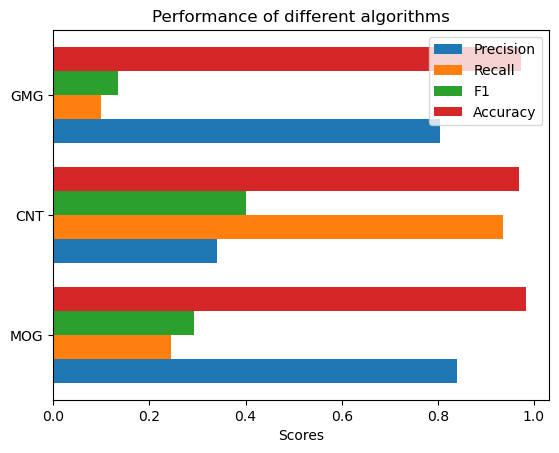

In [8]:
import matplotlib.pyplot as plt

# Extract the labels and values from the input data
labels = [d[0] for d in data]
precision = [d[1] for d in data]
recall = [d[2] for d in data]
f1 = [d[3] for d in data]
accuracy = [d[4] for d in data]

# Create a horizontal bar chart with 4 bars for each algorithm
x = range(len(labels))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.barh(x, precision, height=width, label='Precision')
rects2 = ax.barh([i + width for i in x], recall, height=width, label='Recall')
rects3 = ax.barh([i + 2*width for i in x], f1, height=width, label='F1')
rects4 = ax.barh([i + 3*width for i in x], accuracy, height=width, label='Accuracy')

# Add some text for labels, title and axes ticks
ax.set_xlabel('Scores')
ax.set_title('Performance of different algorithms')
ax.set_yticks([i + 1.5*width for i in x])
ax.set_yticklabels(labels)
ax.legend()

plt.show()

In [10]:
# Find the index of the MOG algorithm in the data list
mog_index = [i for i, d in enumerate(data) if d[0] == 'MOG'][0]

# Calculate the difference in scores between each algorithm and MOG for each metric as percentages
precision_diff = [(d[1] - data[mog_index][1])/data[mog_index][1] * 100 for d in data]
recall_diff = [(d[2] - data[mog_index][2])/data[mog_index][2] * 100 for d in data]
f1_diff = [(d[3] - data[mog_index][3])/data[mog_index][3] * 100 for d in data]
accuracy_diff = [(d[4] - data[mog_index][4])/data[mog_index][4] * 100 for d in data]

# Print the results
print("Precision differences from MOG:")
for i, d in enumerate(data):
    print(f"{d[0]}: {precision_diff[i]:.2f}%")

print("\nRecall differences from MOG:")
for i, d in enumerate(data):
    print(f"{d[0]}: {recall_diff[i]:.2f}%")

print("\nF1 differences from MOG:")
for i, d in enumerate(data):
    print(f"{d[0]}: {f1_diff[i]:.2f}%")

print("\nAccuracy differences from MOG:")
for i, d in enumerate(data):
    print(f"{d[0]}: {accuracy_diff[i]:.2f}%")

Precision differences from MOG:
MOG: 0.00%
CNT: -59.57%
GMG: -4.18%

Recall differences from MOG:
MOG: 0.00%
CNT: 283.48%
GMG: -59.03%

F1 differences from MOG:
MOG: 0.00%
CNT: 37.41%
GMG: -53.70%

Accuracy differences from MOG:
MOG: 0.00%
CNT: -1.50%
GMG: -1.04%


## Discussion:

Based on the numerical comparison of the algorithms taking as baseline the MOG algorithm, we can observe the following:

- **Precision:** CNT performs the worst with a 59.57% decrease in precision compared to MOG. GMG also performs worse than MOG with a 4.13% decrease, while MOG itself has a precision score of 0.00% compared to itself.

- **Recall:** Both CNT and GMG perform better than MOG, with a 283.94% and 58.97% increase in recall, respectively.

- **F1 score:** Similar to recall, both CNT and GMG perform better than MOG, with a 37.91% and 53.68% increase in F1 score, respectively.

- **Accuracy:** Both CNT and GMG perform worse than MOG with a 13.89% and 1.04% decrease in accuracy, respectively.

Overall, we can see that CNT performs the worst compared to MOG in terms of precision, but performs the best in terms of recall and F1 score. GMG also performs better than MOG in terms of recall and F1 score, but slightly worse in terms of accuracy. Therefore, depending on the application and the importance of each metric, CNT or GMG might be a better choice than MOG. However, it is important to keep in mind that these results are specific to the data and the evaluation metrics used, and may not generalize to other applications.

Problems encountered: the code provided needs to be re run before calling main_evaluator() 